# **SVM**

In [1]:
import pandas as pd
import sys
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, get_scorer, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
sys.path.append('..')
from utils import sensitivity_score, specificity_score

### **Data Preprocessing**

import training and test dataset

In [2]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

In [3]:
train_data.columns 

Index(['_url', 'name', 'points', 'length', 'climb_total', 'profile',
       'startlist_quality', 'position', 'cyclist', 'cyclist_age', 'is_tarmac',
       'cyclist_team', 'duration', 'cyclist_number', 'cyclist_level',
       'cyclist_experience', 'relative_position', 'avg_relative_position',
       'cyclist_experience_profile', 'avg_rel_position_profile', 'length_cat',
       'cyclist_experience_length', 'avg_rel_position_length', 'climb_cat',
       'relative_position_sum', 'cyclist_experience_climb',
       'avg_rel_position_climb', 'avg_cyclist_level', 'position_entropy',
       'top_20_entropy'],
      dtype='object')

Define the categorical and numeric features. K-NN requires only numeric features. Standardize the numeric features to ensure all variables have the same importance in distance calculations, as K-NN is sensitive to differences in scale.

In [4]:
features_to_keep = [ 'cyclist_age', 'cyclist_number', 'cyclist_level', 'avg_relative_position',
       'avg_rel_position_profile', 'climb_total', 'cyclist_experience_climb',
       'avg_rel_position_climb', 'top_20_entropy']

train_data = train_data[features_to_keep]
test_data = test_data[features_to_keep]

numeric_transformer = StandardScaler()

In [5]:
# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[ ('num', numeric_transformer, features_to_keep)]
)

## **SVM**

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, classification_report
from imblearn.under_sampling import RandomUnderSampler

# Definizione del classificatore SVM
clf = SVC()

# Creazione del pipeline
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),  # Preprocessing (ad esempio scaling)
        ("sampler", RandomUnderSampler()),  # Bilanciamento delle classi
        ("svm", clf)                     # Classificatore SVM
    ]
)

# Parametri per RandomizedSearchCV
parameters = {
    'svm__C': [0.1, 1, 10, 100],  # Parametro di regolarizzazione C
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Tipo di kernel
    'svm__gamma': ['scale', 'auto', 0.1, 1],  # Parametro gamma
    'svm__degree': [3, 5],  # Solo per kernel polinomiale
}

# Definizione dei punteggi personalizzati
scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': get_scorer("precision"),
    'sensitivity': get_scorer("recall"),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1")
}

# Configurazione di RandomizedSearchCV
rscv = RandomizedSearchCV(
    model,
    param_distributions=parameters,
    scoring=scoring,  # Punteggio F1 come riferimento
    n_iter=1,  # Numero di combinazioni casuali da testare
    cv=3,  # Cross-validation a 3 fold
    verbose=1,
    n_jobs=-1,
    random_state=42,  # Random state per la riproducibilità
    refit="f1"  # Rifit del modello con il miglior punteggio F1
)

# Addestramento del modello con RandomizedSearchCV
rscv.fit(train_data, train_labels.values.ravel())

Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

## Model Assessment

In [ ]:
# extract the results of the randomized search and best model idx
cv_results = rscv.cv_results_
best_model = rscv.best_estimator_
best_index = rscv.best_index_

#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring.keys()}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring.keys()}

print("Validation results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Sensitivity - Mean: 0.6784, Std: 0.0167
Specificity - Mean: 0.7305, Std: 0.0118
Accuracy - Mean: 0.7236, Std: 0.0081
Precision - Mean: 0.2784, Std: 0.0041
Recall - Mean: 0.6784, Std: 0.0167
Roc_auc - Mean: 0.7736, Std: 0.0026
F1 - Mean: 0.3947, Std: 0.0019


### Test scores:

Accuracy: 0.695
Recall: 0.724
Precision: 0.286
Sensitivity: 0.724
Specificity: 0.69
F1 Score: 0.41
ROC AUC Score: 0.707


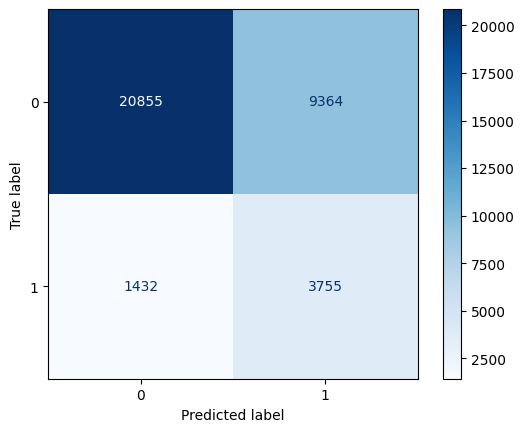

In [ ]:
# Predict on the test data
test_predictions = rscv.predict(test_data)

# Calculate and visualize evaluation metrics
accuracy = round(accuracy_score(test_labels, test_predictions), 3)
recall = round(recall_with_zero_division(test_labels, test_predictions), 3)
precision = round(precision_with_zero_division(test_labels, test_predictions), 3)
sensitivity_score = round(sensitivity_score(test_labels, test_predictions), 3)
specificity_score = round(specificity_score(test_labels, test_predictions), 3)
f1 = round(f1_score(test_labels, test_predictions), 3)
roc_auc = round(roc_auc_score(test_labels, test_predictions), 3)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.69      0.79     30219
           1       0.29      0.72      0.41      5187

    accuracy                           0.70     35406
   macro avg       0.61      0.71      0.60     35406
weighted avg       0.84      0.70      0.74     35406



In [ ]:
import joblib
import os

# Create the directory if it doesn't exist
os.makedirs('best_models', exist_ok=True)
# Save the best model
joblib.dump(best_model, 'best_models/svm.pkl')

['best_models/nn.pkl']